## Importing libraries

In [137]:
import time
import os
import math
import json
import requests
import random
import numpy as np
import matplotlib.pyplot as plt

from elasticsearch7 import Elasticsearch
from elasticsearch7.client import IndicesClient

## Elastic Search

In [3]:
cloud_id='My_deployment:dXMtY2VudHJhbDEuZ2NwLmNsb3VkLmVzLmlvOjQ0MyQyNmZjZGU3MDU2ODQ0M2ExOGU4MGNkY2U3ZjQ0NDFhNiQxYmE5MjY3ODFkM2E0NTNiYTkzZjEzZDMxYjU2MDUzMQ=='
es=Elasticsearch(request_timeout=10000, cloud_id=cloud_id, http_auth=('elastic', 'zwrRY5OjRfw8xvYaHRNSx78Y'))

In [45]:
def searchQuery(query):
    data = {
        "query": {
            "match": {
                "content": {
                    "query": query
                }
            }
        },
        "size": 200
    }
    
    result = es.search(index="hw3", body=data)

    top = []

    for hit in result['hits']['hits']:
        url = hit['_source']['url']
        score = hit['_score']
        top.append((score, url))
    
    return top

In [ ]:
def writeScores(fileName, queryNum, scores):
    f  = open(fileName, "a")
    for index, el in enumerate(scores):
        score, docId = el

        lineContents = f'{queryNum} Q0 {docId} {index + 1} {score} Exp\n'
        f.write(lineContents)
    f.close()

In [52]:
queries = ["chernobyl accident", "Fukushima nuclear accident", "Three Mile Island accident", "kyshtym disaster"]

In [53]:
for qid, query in enumerate(queries):
    print(query)
    
    top = searchQuery(query)
    writeScores("../Results/result.txt", qid + 1, top)

chernobyl accident


/var/folders/fw/dcqd5fmj55dbv9x3cfw88swr0000gn/T/ipykernel_43561/3697596758.py:13: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  result = es.search(index="hw3", body=data)


Fukushima nuclear accident
Three Mile Island accident
kyshtym disaster


## Eval function

In [179]:
!perl ./trec_eval.pl ./QREL/qrel.txt ../Results/result.txt

Error due to 4

Queryid (Num):        4
Total number of documents over all queries
    Retrieved:      785
    Relevant:       644
    Rel_ret:        414
Interpolated Recall - Precision Averages:
    at 0.00       1.9167
    at 0.10       1.5016
    at 0.20       1.3870
    at 0.30       0.9614
    at 0.40       0.9572
    at 0.50       0.6347
    at 0.60       0.5805
    at 0.70       0.5344
    at 0.80       0.4969
    at 0.90       0.2982
    at 1.00       0.0000
Average precision (non-interpolated) for all rel docs(averaged over queries)
                  0.7880
Precision:
  At    1 docs:   1.7500
  At    2 docs:   1.8750
  At    3 docs:   1.8333
  At    4 docs:   1.6250
  At    5 docs:   1.6000
  At   10 docs:   1.5000
  At   15 docs:   1.4333
  At   20 docs:   1.2625
  At   30 docs:   1.2167
  At  100 docs:   0.7875
  At  200 docs:   0.5175
  At  500 docs:   0.2070
  At 1000 docs:   0.1035
R-Precision (precision after R (= num_rel for a query) docs retrieved):
    Exact:        

In [64]:
def getQrelData(filePath):
    qrel, numRel = {}, {}
    
    with open(filePath, 'r') as f:
        qrel_data = f.read().split()

    for i in range(0, len(qrel_data), 4):
        topic, assessorId, url, rel = qrel_data[i:i+4]
        qrel.setdefault(topic, {})[url] = rel
        numRel[topic] = numRel.get(topic, 0) + int(rel)

    return qrel, numRel

qrel, numRel = getQrelData("./QREL/qrel.txt")

In [65]:
def getResultData(filePath):
    with open(filePath, 'r') as f:
        resultData = f.read().split()

    result = {}

    for i in range(0, len(resultData), 6):
        topic, _, url, _, score, _ = resultData[i:i+6]
        result.setdefault(topic, {})[url] = float(score)

    return result


result = getResultData("../Results/result.txt")

In [119]:
def evaluate_dcg(scores):
    dcg = float(scores[0])
    for rank in range(1, len(scores)):
        dcg += float(scores[rank]) / np.log2(rank + 1)
    return dcg


def calculateNdcg(qrel, elements):
    ndcg = {}
    
    for index, element in enumerate(elements):
        scoresHashMap = qrel[element]
        scores = [val for val in scoresHashMap.values()] 

        dcg = evaluate_dcg(scores)
        idcg = evaluate_dcg(sorted(scores, reverse=True))
        ndcg[index] = dcg / idcg if idcg else 0
        
    return np.mean(list(ndcg.values()))

In [129]:
CUTOFFS= [5, 10, 20, 50, 100]
def plot_curves(query,avg_prec_list,avg_recall_list):
    plt.figure(figsize=(8, 5))
    plt.plot(CUTOFFS, avg_prec_list, marker='o', linestyle='-', color='b')
    plt.plot(CUTOFFS,avg_recall_list,marker='o',color='r')
    plt.xlabel('Cutoffs')
    plt.title(f'Precision-Recall Curve for Query - {query}')
    plt.grid(True)
    plt.show()

In [130]:
def printMetrics(query, avg_r_prec, mean_avg_prec, avg_prec_at_cutoffs, avg_recalls_at_cutoffs, ndcg, docCutoffs):
    print("\n**************************************************************\n")
    print(f'Metrics for {query}')
    
    col = ['Doc nos', 'Value']

    print("\nR-precision: ", format(avg_r_prec, '.3f'))
    print("\nAverage precision: ", format(mean_avg_prec, '.3f'))
    print(f'\nndcg: {format(ndcg, '.4f')}')
    
    print("\n****************** Precision values ******************")
    print(f'{col[0]:<15} {col[1]:<25}')
    for index, prec in enumerate(avg_prec_at_cutoffs):
        print(f'{docCutoffs[index]:<15} {format(prec, '.3f'):<25}')
    
    print("\n****************** Recall values ******************")
    print(f'{col[0]:<15} {col[1]:<25}')
    for index, rec in enumerate(avg_recalls_at_cutoffs):
        print(f'{docCutoffs[index]:<15} {format(rec, '.3f'):<25}')
    
    print("\n****************** F1 values ******************")
    print(f'{col[0]:<15} {col[1]:<25}')
    for index in range(len(docCutoffs)):
        p = avg_prec_at_cutoffs[index]
        r = avg_recalls_at_cutoffs[index]
        f1 = (2 * p * r) / (p + r) 
        print(f'{docCutoffs[index]:<15} {format(f1, '.3f'):<25}')

In [131]:
def execute(result, option):
    queryIds = sorted(result.keys())
    arr = []
    
    if option:
        for queryId in queryIds:
            arr.append([queryId])

    arr.append(queryIds)

    for index, element in enumerate(arr):
        docCutoffs = [5, 10, 20, 50, 100]

        num_topics = 0
        tot_num_ret = 0
        tot_num_rel = 0
        tot_num_rel_ret = 0
        sum_prec_at_cutoffs = [0] * len(docCutoffs)
        sum_recalls_at_cutoffs = [0] * len(docCutoffs)
        sum_avg_prec = 0
        sum_r_prec = 0
        
        maxDocs = 801

        for topic in sorted(element):
            if not numRel.get(topic):
                continue
    
            num_topics += 1
            href = result[topic]
            prec_list = [0] * (maxDocs + 1)
            rec_list = [0] * (maxDocs + 1)
            num_ret = 0
            num_rel_ret = 0
            sum_prec = 0
    
            for doc_id in sorted(href.keys(), key=lambda x: (href[x], x), reverse=True):
                num_ret += 1
                rel = int(qrel.get(topic, {}).get(doc_id, 0))
        
                if rel:
                    sum_prec += rel * (1 + num_rel_ret) / num_ret
                    num_rel_ret += rel
        
                prec_list[num_ret] = num_rel_ret / num_ret
                rec_list[num_ret] = num_rel_ret / numRel[topic]
        
            avg_prec = sum_prec / numRel[topic]
        
            final_recall = num_rel_ret / numRel[topic]
        
            prec_at_cutoffs = [prec_list[cutoff] for cutoff in docCutoffs]
            recall_at_cutoffs = [rec_list[cutoff] for cutoff in docCutoffs]
    
            if numRel[topic] > num_ret:
                r_prec = num_rel_ret / numRel[topic]
            else:
                int_num_rel = int(numRel[topic])
                frac_num_rel = numRel[topic] - int_num_rel
                r_prec = (1 - frac_num_rel) * prec_list[int_num_rel] + frac_num_rel * prec_list[int_num_rel + 1] if frac_num_rel > 0 else prec_list[int_num_rel]
        
            max_prec, max_rec = 0, 0
            for i in range(maxDocs, 0, -1):
                max_prec = max(max_prec, prec_list[i])
                max_rec = max(max_rec, rec_list[i])
                
                prec_list[i] = max_prec
                rec_list[i] = max_rec
                
            tot_num_ret += num_ret
            tot_num_rel += numRel[topic]
            tot_num_rel_ret += num_rel_ret
    
            for i, cutoff in enumerate(docCutoffs):
                sum_prec_at_cutoffs[i] += prec_at_cutoffs[i]
        
            for i, recall in enumerate(docCutoffs):
                sum_recalls_at_cutoffs[i] += recall_at_cutoffs[i]
        
            sum_avg_prec += avg_prec
            sum_r_prec += r_prec
    
        avg_prec_at_cutoffs = [sum_prec / num_topics for sum_prec in sum_prec_at_cutoffs]
        avg_recalls_at_cutoffs = [sum_rec / num_topics for sum_rec in sum_recalls_at_cutoffs]
        mean_avg_prec = sum_avg_prec / num_topics
        avg_r_prec = sum_r_prec / num_topics
        ndcg = calculateNdcg(qrel, element)

        queryName = f'Query-{element[0]}' if len(element) == 1 else "Average"
        printMetrics(queryName, avg_r_prec, mean_avg_prec, avg_prec_at_cutoffs, avg_recalls_at_cutoffs, ndcg, docCutoffs)
        
        if len(element) == 1:
            plot_curves(queryName, avg_prec_at_cutoffs, avg_recalls_at_cutoffs)


**************************************************************

Metrics for Query-1

R-precision:  0.458

Average precision:  0.534

ndcg: 0.9011

****************** Precision values ******************
Doc nos         Value                    
5               1.400                    
10              1.300                    
20              1.000                    
50              0.980                    
100             0.490                    

****************** Recall values ******************
Doc nos         Value                    
5               0.065                    
10              0.121                    
20              0.187                    
50              0.458                    
100             0.458                    

****************** F1 values ******************
Doc nos         Value                    
5               0.125                    
10              0.222                    
20              0.315                    
50              0.624  

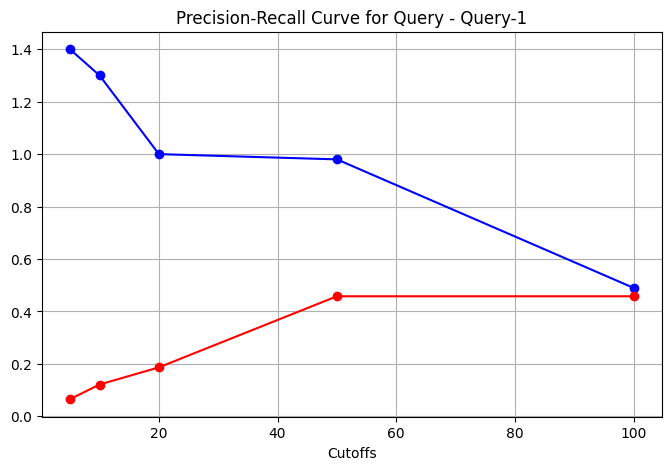


**************************************************************

Metrics for Query-2

R-precision:  0.986

Average precision:  1.378

ndcg: 0.9541

****************** Precision values ******************
Doc nos         Value                    
5               1.600                    
10              1.600                    
20              1.400                    
50              1.620                    
100             1.350                    

****************** Recall values ******************
Doc nos         Value                    
5               0.037                    
10              0.073                    
20              0.128                    
50              0.370                    
100             0.616                    

****************** F1 values ******************
Doc nos         Value                    
5               0.071                    
10              0.140                    
20              0.234                    
50              0.602  

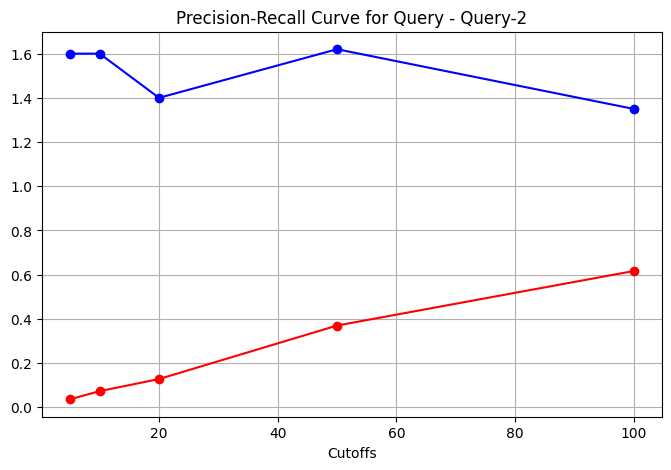


**************************************************************

Metrics for Query-3

R-precision:  0.227

Average precision:  0.350

ndcg: 0.9669

****************** Precision values ******************
Doc nos         Value                    
5               2.000                    
10              1.800                    
20              1.500                    
50              0.920                    
100             0.460                    

****************** Recall values ******************
Doc nos         Value                    
5               0.049                    
10              0.089                    
20              0.148                    
50              0.227                    
100             0.227                    

****************** F1 values ******************
Doc nos         Value                    
5               0.096                    
10              0.169                    
20              0.269                    
50              0.364  

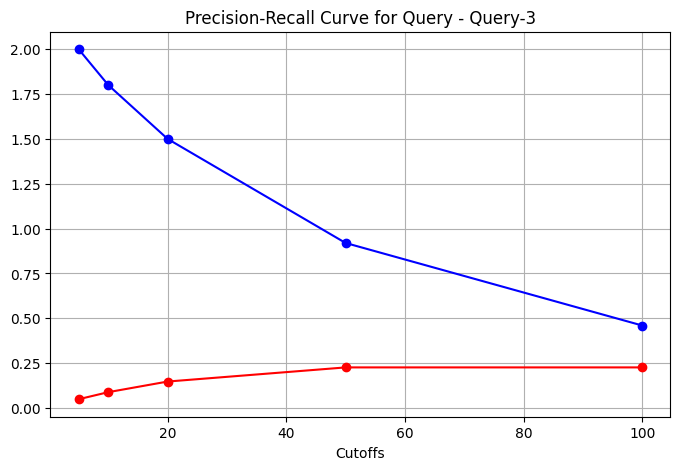


**************************************************************

Metrics for Query-4

R-precision:  0.757

Average precision:  0.889

ndcg: 0.9024

****************** Precision values ******************
Doc nos         Value                    
5               1.400                    
10              1.300                    
20              1.150                    
50              1.020                    
100             0.850                    

****************** Recall values ******************
Doc nos         Value                    
5               0.061                    
10              0.113                    
20              0.200                    
50              0.443                    
100             0.739                    

****************** F1 values ******************
Doc nos         Value                    
5               0.117                    
10              0.208                    
20              0.341                    
50              0.618  

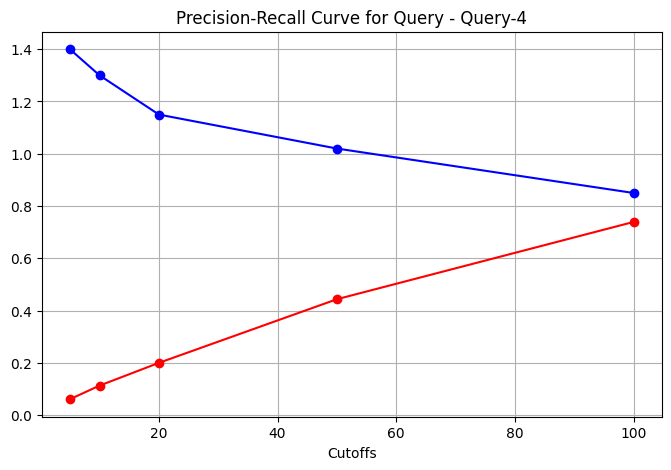


**************************************************************

Metrics for Average

R-precision:  0.607

Average precision:  0.788

ndcg: 0.9311

****************** Precision values ******************
Doc nos         Value                    
5               1.600                    
10              1.500                    
20              1.262                    
50              1.135                    
100             0.788                    

****************** Recall values ******************
Doc nos         Value                    
5               0.053                    
10              0.099                    
20              0.166                    
50              0.374                    
100             0.510                    

****************** F1 values ******************
Doc nos         Value                    
5               0.103                    
10              0.186                    
20              0.293                    
50              0.563  

In [138]:
execute(result, True)

In [139]:
execute(result, False)


**************************************************************

Metrics for Average

R-precision:  0.607

Average precision:  0.788

ndcg: 0.9311

****************** Precision values ******************
Doc nos         Value                    
5               1.600                    
10              1.500                    
20              1.262                    
50              1.135                    
100             0.788                    

****************** Recall values ******************
Doc nos         Value                    
5               0.053                    
10              0.099                    
20              0.166                    
50              0.374                    
100             0.510                    

****************** F1 values ******************
Doc nos         Value                    
5               0.103                    
10              0.186                    
20              0.293                    
50              0.563  